# Xarray + Cloud OISST (One-Month) Basics & Stats

This notebook demonstrates basic **xarray** operations on a **one-month** subset of a cloud-hosted climate dataset: **NOAA OISST v2.1 daily SST** on AWS Public Datasets (NetCDF files). You'll:
- Discover files for one month on S3 with `fsspec`
- Open them with `xarray.open_mfdataset` (anonymous S3)
- Inspect dataset structure
- Subset in space (and within that month)
- Compute basic stats (mean, std, anomalies relative to the month’s mean)
- Make maps of the month-mean and variability

**Deliverables:** Answer the **🧩 Questions** in the markdown prompts. Fill in the code where indicated by `# TODO`.


In [1]:
import xarray as xr
import fsspec
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.dpi'] = 120


## 1) Open the cloud dataset (NetCDF on AWS, one month)

We'll access **NOAA OISST v2.1 (daily)** in the NOAA CDR bucket on AWS. Files are arranged by **YYYYMM**.

**🧩 Questions**
1. What engine are we using to read NetCDF files from S3?
2. Why do we need `storage_options={'anon': True}`?
3. Inspect dataset attributes: what are the units and long name of `sst`?

**💡Answers**
1. h5netcdf - works well with remote data
2. Indicates no authentication is needed to accesss the data. Common for public access data.
3. long_name: Daily sea surface temperature, units : Celsius

In [2]:
import os
from pathlib import Path

yearmonth = "201508"  # TODO: try other months like "201507" or "201909"

# Simple file-based caching since I'm running this notebook a lot
cache_dir = Path("data_cache")
cache_dir.mkdir(exist_ok=True)
cache_file = cache_dir / f"oisst_{yearmonth}.nc"

if cache_file.exists():
    print(f"Loading cached data from {cache_file}")
    ds = xr.open_dataset(cache_file, chunks={"time": 1})
else:
    print(f"Downloading and caching data for {yearmonth}")
    
    # Original S3 access code
    prefix = f"noaa-cdr-sea-surface-temp-optimum-interpolation-pds/data/v2.1/avhrr/{yearmonth}/oisst-avhrr-v02r01.*.nc"
    fs = fsspec.filesystem("s3", anon=True)
    paths = sorted(fs.glob(prefix))
    print(f"Found {len(paths)} files for {yearmonth}. Example:", paths[:2])
    
    urls = [f"s3://{p}" for p in paths]
    
    ds = xr.open_mfdataset(
        urls,
        engine="h5netcdf",
        combine="by_coords",
        decode_times=True,
        mask_and_scale=True,
        backend_kwargs={"storage_options": {"anon": True}},
        chunks={"time": 1}
    )
    
    # Cache the dataset
    print(f"Saving to cache: {cache_file}")
    ds.to_netcdf(cache_file)

print("Dataset loaded successfully!")
ds['sst']


Loading cached data from data_cache\oisst_201508.nc
Dataset loaded successfully!


C:\Users\ztors\AppData\Local\Temp\ipykernel_2448\787689111.py:13: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(cache_file, chunks={"time": 1})


<xarray.DataArray 'sst' (time: 31, zlev: 1, lat: 720, lon: 1440)> Size: 129MB
dask.array<open_dataset-sst, shape=(31, 1, 720, 1440), dtype=float32, chunksize=(1, 1, 360, 720), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time     (time) datetime64[ns] 248B 2015-08-01T12:00:00 ... 2015-08-31T12...
  * zlev     (zlev) float32 4B 0.0
Attributes:
    long_name:  Daily sea surface temperature
    units:      Celsius
    valid_min:  -300
    valid_max:  4500

## 2) Explore coordinates & variables

**🧩 Questions**
1. What are the coordinate names for time and space?
2. What is the shape of `sst`?
3. How are missing values represented?

**💡Answers**
1. - lat  - latitude
   - lon  - longitude
   - time     
   - zlev - depth
2. (31, 1, 720, 1440)
3. `mask_and_scale=true` sets them to NaN

In [3]:
print(ds.coords)

print(ds['sst'].shape)

Coordinates:
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time     (time) datetime64[ns] 248B 2015-08-01T12:00:00 ... 2015-08-31T12...
  * zlev     (zlev) float32 4B 0.0
(31, 1, 720, 1440)


## 3) Time & space subsetting

We'll select a **regional box** (e.g., Gulf of Mexico) within this month.

**🧩 Questions**
1. What lon/lat bounds did you choose?
2. How many daily steps are present in this month?

**💡Answers**
1. Northern Sea of Cortez
2. Can see from the shape of the ds that there are 31 steps. That makes sense since August has 31 days.

In [4]:
var = "sst"

lon_min, lon_max = -115, -108
lat_min, lat_max = 28, 32

def to_0360(lon):
    lon = np.asarray(lon)
    out = np.mod(lon, 360.0)
    out[out < 0] += 360.0
    return out

lon_min_0360, lon_max_0360 = to_0360([lon_min, lon_max])

dss = ds.sel(
    lon=slice(lon_min_0360, lon_max_0360),
    lat=slice(lat_min, lat_max)
)

dss[var]


<xarray.DataArray 'sst' (time: 31, zlev: 1, lat: 16, lon: 28)> Size: 56kB
dask.array<getitem, shape=(31, 1, 16, 28), dtype=float32, chunksize=(1, 1, 16, 28), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 64B 28.12 28.38 28.62 28.88 ... 31.38 31.62 31.88
  * lon      (lon) float32 112B 245.1 245.4 245.6 245.9 ... 251.4 251.6 251.9
  * time     (time) datetime64[ns] 248B 2015-08-01T12:00:00 ... 2015-08-31T12...
  * zlev     (zlev) float32 4B 0.0
Attributes:
    long_name:  Daily sea surface temperature
    units:      Celsius
    valid_min:  -300
    valid_max:  4500

## 4) Basic statistics

Compute region-wide stats through time and over space **within this month**.

**🧩 Questions**
1. Compute the spatial mean SST time series over your box. What is the monthly average and standard deviation?
2. Compute within-month anomalies (subtract the month-mean). What are the largest positive and negative anomalies?
3. What day had the warmest/coolest region-mean SST?

**💡Answers**
1. Month mean SST (°C): 29.88059425354004

   Month std SST (°C): 0.21616911888122559

2. *Note these are average anomalies* 

   Max anomaly (°C): 0.3855510354042053

   Min anomaly (°C): -0.35299190878868103

3. Warmest day: 2015-08-25 30.266143798828125

   Coolest day: 2015-08-06 29.527603149414062

Month mean SST (°C): 29.589807510375977
Month std SST (°C): 0.5701608061790466


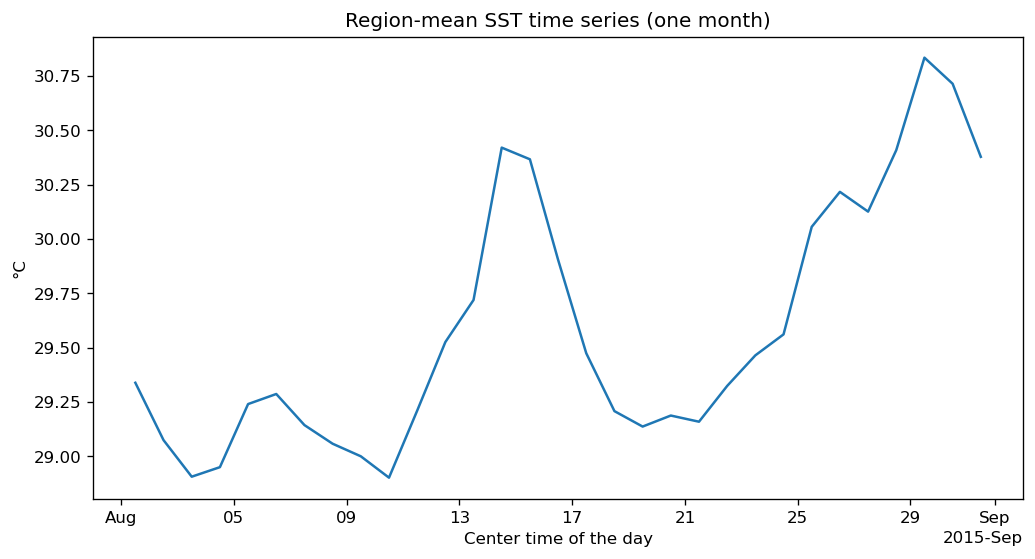

Warmest day: 2015-08-29 30.833660125732422
Coolest day: 2015-08-10 28.90151596069336


C:\Users\ztors\AppData\Local\Temp\ipykernel_2448\4248732439.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Warmest day:', pd.to_datetime(ts.time[imax].values).date(), float(ts.isel(time=imax).values))
C:\Users\ztors\AppData\Local\Temp\ipykernel_2448\4248732439.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Coolest day:', pd.to_datetime(ts.time[imin].values).date(), float(ts.isel(time=imin).values))


c:\source\module-2-check-in-zrtorstrick\.conda\Lib\site-packages\dask\array\numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
c:\source\module-2-check-in-zrtorstrick\.conda\Lib\site-packages\dask\array\numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [5]:
# Computes a mean temp over the entire box for each day
ts = dss[var].mean(dim=['lat','lon'])

# Gets a mean and std for the entire month
ts_mean = ts.mean().compute()
ts_std  = ts.std().compute()
print('Month mean SST (°C):', float(ts_mean.values))
print('Month std SST (°C):', float(ts_std.values))

ts.load().plot()
plt.title('Region-mean SST time series (one month)')
plt.ylabel('°C')
plt.show()

imax = int(ts.argmax('time'))
imin = int(ts.argmin('time'))
print('Warmest day:', pd.to_datetime(ts.time[imax].values).date(), float(ts.isel(time=imax).values))
print('Coolest day:', pd.to_datetime(ts.time[imin].values).date(), float(ts.isel(time=imin).values))


Max anomaly (°C): 1.2438507080078125
Min anomaly (°C): -0.6882919669151306


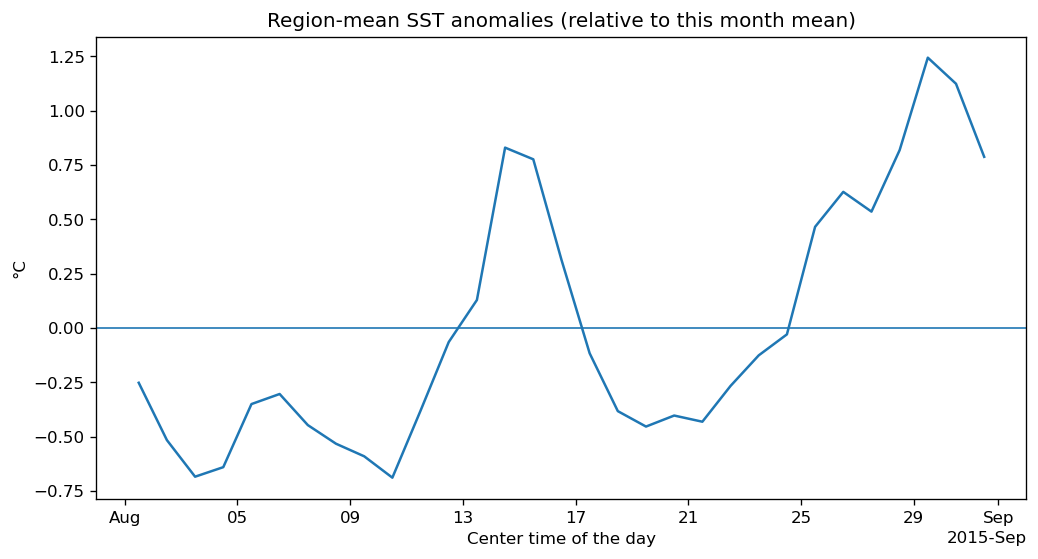

In [6]:
# Get a monthly mean for each point
month_mean = dss[var].mean('time')

# Get the distance from the mean at each point in space/time
anom = dss[var] - month_mean

ts_anom = anom.mean(dim=['lat','lon'])
print('Max anomaly (°C):', float(ts_anom.max().compute().values))
print('Min anomaly (°C):', float(ts_anom.min().compute().values))

ts_anom.load().plot()
plt.title('Region-mean SST anomalies (relative to this month mean)')
plt.axhline(0, lw=1)
plt.ylabel('°C')
plt.show()


## 5) Regional maps: month-mean and variability

Make maps of month-mean SST and within-month variability (std and range).

**🧩 Questions**
1. What patterns do you notice?
2. Where is variability strongest?

**💡Answers**
1. STD and Range tend to increase and decrease together. This makes sense, since a larger range means more potential for data spread. Waters to the south are warmer.
2. Coastal regions have more variability. Perhaps due to shallower waters?


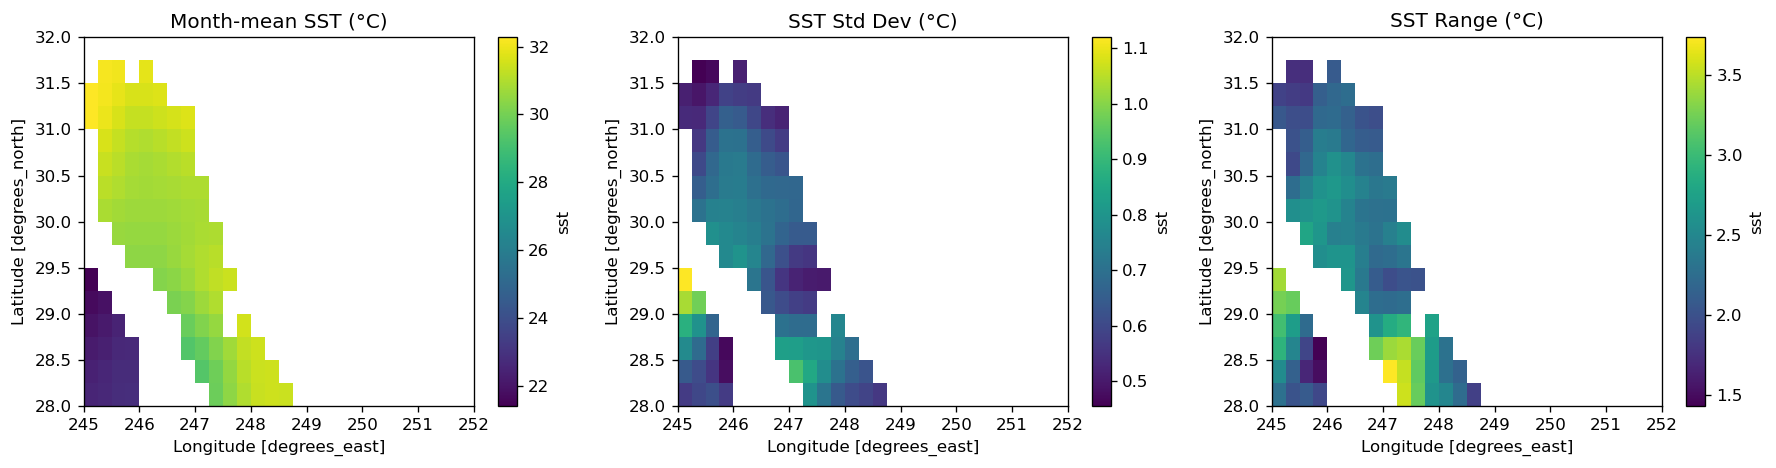

In [7]:
mean_sst = dss[var].mean('time')
std_sst  = dss[var].std('time')
range_sst = dss[var].max('time') - dss[var].min('time')

fig = plt.figure(figsize=(15,4))
ax = plt.subplot(1,3,1); mean_sst.plot(ax=ax); ax.set_title('Month-mean SST (°C)')
ax = plt.subplot(1,3,2); std_sst.plot(ax=ax); ax.set_title('SST Std Dev (°C)')
ax = plt.subplot(1,3,3); range_sst.plot(ax=ax); ax.set_title('SST Range (°C)')
plt.tight_layout(); plt.show()


## 6) Export a small subset for sharing (Check In Problem for Module 2)

Write a NetCDF with your regional mean time series and month-mean/variability maps.  Upload with your committed repository.

In [8]:
# Create a dataset combining time series and spatial maps for export
import xarray as xr

# Regional mean time series (already computed)
# ts = regional mean SST time series
# ts_anom = regional mean anomaly time series

# Spatial maps (already computed) 
# mean_sst = month-mean SST map
# std_sst = SST standard deviation map  
# range_sst = SST range map

# Create a new dataset for export
export_ds = xr.Dataset({
    # Time series data
    'regional_mean_sst': ts,
    'regional_mean_anomaly': ts_anom,
    
    # Spatial maps (month-mean and variability)
    'month_mean_sst': mean_sst,
    'sst_std_dev': std_sst,
    'sst_range': range_sst
})

# Add metadata attributes
export_ds.attrs['title'] = 'Northern Sea of Cortez SST Analysis - August 2015'
export_ds.attrs['description'] = 'Regional mean time series and month-mean/variability maps'
export_ds.attrs['source'] = 'NOAA OISST v2.1 daily SST'
export_ds.attrs['region'] = 'Northern Sea of Cortez (Gulf of California)'
export_ds.attrs['time_period'] = 'August 2015'
export_ds.attrs['spatial_bounds'] = f'lat: {lat_min}-{lat_max}, lon: {lon_min}-{lon_max}'

# Add variable descriptions
export_ds['regional_mean_sst'].attrs['long_name'] = 'Regional mean sea surface temperature'
export_ds['regional_mean_sst'].attrs['units'] = 'Celsius'

export_ds['regional_mean_anomaly'].attrs['long_name'] = 'Regional mean SST anomaly relative to August mean'
export_ds['regional_mean_anomaly'].attrs['units'] = 'Celsius'

export_ds['month_mean_sst'].attrs['long_name'] = 'August mean sea surface temperature'
export_ds['month_mean_sst'].attrs['units'] = 'Celsius'

export_ds['sst_std_dev'].attrs['long_name'] = 'SST standard deviation within August'
export_ds['sst_std_dev'].attrs['units'] = 'Celsius'

export_ds['sst_range'].attrs['long_name'] = 'SST range (max - min) within August'
export_ds['sst_range'].attrs['units'] = 'Celsius'

# Export to NetCDF file
output_file = 'sea_of_cortez_sst_analysis_aug2015.nc'
export_ds.to_netcdf(output_file)

print(f"✅ Exported data to: {output_file}")
print(f"📊 Dataset contains:")
print(f"   - Regional time series: {len(ts)} daily values")
print(f"   - Spatial maps: {mean_sst.shape} grid points")
print(f"   - File size: ~{export_ds.nbytes / 1024:.1f} KB")

# Display the exported dataset structure
print("\n📋 Exported dataset structure:")
export_ds


✅ Exported data to: sea_of_cortez_sst_analysis_aug2015.nc
📊 Dataset contains:
   - Regional time series: 31 daily values
   - Spatial maps: (1, 16, 28) grid points
   - File size: ~5.9 KB

📋 Exported dataset structure:


<xarray.Dataset> Size: 6kB
Dimensions:                (time: 31, zlev: 1, lat: 16, lon: 28)
Coordinates:
  * time                   (time) datetime64[ns] 248B 2015-08-01T12:00:00 ......
  * zlev                   (zlev) float32 4B 0.0
  * lat                    (lat) float32 64B 28.12 28.38 28.62 ... 31.62 31.88
  * lon                    (lon) float32 112B 245.1 245.4 245.6 ... 251.6 251.9
Data variables:
    regional_mean_sst      (time, zlev) float32 124B 29.34 29.07 ... 30.71 30.38
    regional_mean_anomaly  (time, zlev) float32 124B -0.2517 -0.5156 ... 0.7877
    month_mean_sst         (zlev, lat, lon) float32 2kB dask.array<chunksize=(1, 16, 28), meta=np.ndarray>
    sst_std_dev            (zlev, lat, lon) float32 2kB dask.array<chunksize=(1, 16, 28), meta=np.ndarray>
    sst_range              (zlev, lat, lon) float32 2kB dask.array<chunksize=(1, 16, 28), meta=np.ndarray>
Attributes:
    title:           Northern Sea of Cortez SST Analysis - August 2015
    description:     Regional mean time series and month-mean/variability maps
    source:          NOAA OISST v2.1 daily SST
    region:          Northern Sea of Cortez (Gulf of California)
    time_period:     August 2015
    spatial_bounds:  lat: 28-32, lon: -115--108